In [2]:
# !pip install git+https://github.com/ClimateImpactLab/xclim@63023d27f89a457c752568ffcec2e9ce9ad7a81a

In [2]:
# ! pip install xclim==0.32.1

In [3]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os 
import gcsfs 
from matplotlib import cm
import warnings 
import xclim 

from science_validation_manual import *

In [4]:
from xclim import sdba, set_options
from xclim.sdba.utils import equally_spaced_nodes

In [72]:
xclim.__version__

'0.32.1'

In [6]:
ref = read_gcs_zarr('gs://scratch-170cd6ec/643c4b73-399d-427a-87be-cc0ab1b401d9/e2e-bcc-csm2-mr-dtr-qxg22-2721721062/rechunked.zarr')
hist = read_gcs_zarr('gs://scratch-170cd6ec/643c4b73-399d-427a-87be-cc0ab1b401d9/e2e-bcc-csm2-mr-dtr-qxg22-1083920341/thresholded.zarr')
sim = read_gcs_zarr('gs://scratch-170cd6ec/643c4b73-399d-427a-87be-cc0ab1b401d9/e2e-bcc-csm2-mr-dtr-qxg22-3490169582/thresholded.zarr')
bc = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/dtr/gn/v20211230093107.zarr')

In [7]:
# define off the rails lat/lon 
target_lat = 70.5
target_lon = 41.5

# QDM model specs
quantiles_n = 100
window_n = 31

In [8]:
ref_dtr = ref['dtr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
hist_dtr = hist['dtr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
bc_dtr = bc['dtr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()

In [58]:
ref_dtr.max()

<xarray.DataArray 'dtr' ()>
array(11.01596928)
Coordinates:
    lat      float64 70.5
    lon      float64 41.5

In [65]:
hist_dtr[6662]

<xarray.DataArray 'dtr' ()>
array(33.543957, dtype=float32)
Coordinates:
    lat      float64 70.5
    lon      float64 41.5
    time     object 2013-03-19 12:00:00
Attributes:
    long_name:      Diurnal Near-Surface Air Temperature Range
    original_name:  dtr
    standard_name:  air_temperature
    units:          K

In [10]:
sim_slice = sim.sel(lon=target_lon, lat=target_lat, method="nearest").load()

In [11]:
ref_dtr_timeslice = ref_dtr.sel(time=slice("1994-12-17", "2014-12-31"))
hist_dtr_timeslice = hist_dtr.sel(time=slice("1994-12-17", "2014-12-31"))

In [62]:
hist_dtr_timeslice.max()

<xarray.DataArray 'dtr' ()>
array(33.54395676)
Coordinates:
    lat      float64 70.5
    lon      float64 41.5

In [87]:
test_quantiles = np.arange(0.01, .91, 0.01)
test_quantiles

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 ])

In [76]:
'''qdm_extrapolate = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_dtr_timeslice,
        hist=hist_dtr_timeslice,
        kind='*',
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=equally_spaced_nodes(int(quantiles_n), eps=None),
    )'''
qdm_extrapolate = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_dtr_timeslice,
        hist=hist_dtr_timeslice,
        kind='*',
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=equally_spaced_nodes(int(quantiles_n), eps=0),
    )

In [88]:
qdm_NO_extrapolate = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_dtr_timeslice,
        hist=hist_dtr_timeslice,
        kind='*',
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=test_quantiles,
    )

In [43]:
qdm_NO_extrapolate_timeslice = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_dtr_timeslice,
        hist=hist_dtr_timeslice,
        kind='*',
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=equally_spaced_nodes(int(50), eps=1e-09),
    )

In [16]:
# dtr_sim = sim_slice['dtr'].sel(time=slice("1959-12-17", "1979"))

dtr_sim = sim_slice['dtr'].sel(time=slice("1960-12-17", "1980-12-31"))

In [17]:
print(len(ref_dtr_timeslice))
print(len(hist_dtr_timeslice))
print(len(ref_dtr))
print(len(hist_dtr))
print(len(dtr_sim))

7315
7315
8030
7315
7315


In [89]:
bc_extrapolate_here = qdm_extrapolate.adjust(dtr_sim)

bc_NO_extrapolate_here = qdm_NO_extrapolate.adjust(dtr_sim)

bc_NO_extrapolate_here_timeslice = qdm_NO_extrapolate_timeslice.adjust(dtr_sim)

Text(0.5, 1.0, 'bias corrected, notebook, \n least extrapolation')

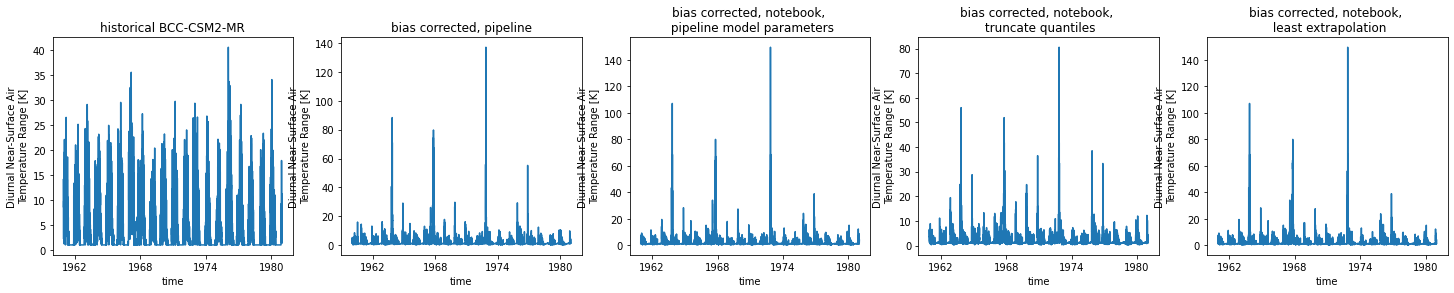

In [90]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))
dtr_sim.plot(ax=axes[0])
axes[0].set_title('historical BCC-CSM2-MR')

bc_dtr.sel(time=slice("1960", "1980")).plot(ax=axes[1])
axes[1].set_title('bias corrected, pipeline')

bc_extrapolate_here.plot(ax=axes[2])
axes[2].set_title('bias corrected, notebook, \n pipeline model parameters')

bc_NO_extrapolate_here.plot(ax=axes[3])
axes[3].set_title('bias corrected, notebook, \n truncate quantiles')

bc_NO_extrapolate_here_timeslice.plot(ax=axes[4])
axes[4].set_title('bias corrected, notebook, \n least extrapolation')

In [63]:
print(bc_NO_extrapolate_here_timeslice[4340].values)
print(dtr_sim[4340].values)

149.6239
26.425629


In [71]:
sim_slice['dtr'].max()

<xarray.DataArray 'dtr' ()>
array(40.53917694)
Coordinates:
    lat      float64 70.5
    lon      float64 41.5

(0.0, 6.0)

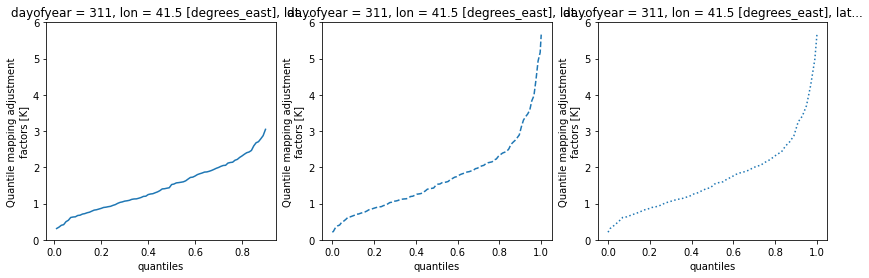

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
qdm_NO_extrapolate.ds.af.sel(dayofyear=311).plot(ax=axes[0], linestyle='-')
axes[0].set_ylim([0, 6])
qdm_extrapolate.ds.af.sel(dayofyear=311).plot(ax=axes[1],linestyle='--')
qdm_NO_extrapolate_timeslice.ds.af.sel(dayofyear=311).plot(ax=axes[2],linestyle=':')
axes[1].set_ylim([0, 6])
axes[2].set_ylim([0, 6])

In [92]:
qdm_NO_extrapolate.ds.af.sel(dayofyear=311)

<xarray.DataArray 'af' (quantiles: 90)>
array([0.31152704, 0.34930688, 0.40022972, 0.41798565, 0.5000863 ,
       0.53849113, 0.6157536 , 0.6288657 , 0.63429576, 0.67101467,
       0.678983  , 0.7099954 , 0.72232175, 0.74612594, 0.76164436,
       0.79090023, 0.81920546, 0.8292582 , 0.8484214 , 0.867449  ,
       0.8919773 , 0.8998217 , 0.9135237 , 0.9238893 , 0.95000994,
       0.97058   , 1.005338  , 1.0316353 , 1.0460618 , 1.0671706 ,
       1.0765446 , 1.0893368 , 1.1153635 , 1.126881  , 1.1294348 ,
       1.1471568 , 1.1677047 , 1.1978667 , 1.2028996 , 1.2476547 ,
       1.2637303 , 1.2719934 , 1.2980773 , 1.3223578 , 1.3563813 ,
       1.4037507 , 1.4096551 , 1.423734  , 1.4365021 , 1.5247655 ,
       1.5389403 , 1.5701768 , 1.5779095 , 1.5881916 , 1.600177  ,
       1.6274952 , 1.6752993 , 1.7205169 , 1.7290261 , 1.7602537 ,
       1.7996553 , 1.8228507 , 1.8427174 , 1.86843   , 1.8730135 ,
       1.8902804 , 1.9130759 , 1.9413242 , 1.9722663 , 1.9959486 ,
       2.0273068 , 2.0507748 , 2.0559971 , 2.1170135 , 2.1332011 ,
       2.141111  , 2.1953738 , 2.2189806 , 2.2735107 , 2.3143797 ,
       2.3614607 , 2.403031  , 2.4232175 , 2.46498   , 2.5914276 ,
       2.6778383 , 2.7065022 , 2.7868884 , 2.8746881 , 3.047487  ],
      dtype=float32)
Coordinates:
  * quantiles  (quantiles) float64 0.01 0.02 0.03 0.04 ... 0.87 0.88 0.89 0.9
    dayofyear  int64 311
    lon        float64 41.5
    lat        float64 70.5
Attributes:
    coordinates:    dayofyear
    units:          K
    kind:           *
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors